In [ ]:
from google.colab import drive

import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

!pip install surprise
from surprise import Reader
from surprise import Trainset
from surprise import Dataset
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise.accuracy import rmse
from collections import defaultdict

meta_file = 'meta_Software.json'
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim.downloader

from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
drive.mount('/content/drive')
datapath = 'drive/MyDrive/data/'
train_test_file = 'Software_5.json'
meta_file = 'meta_Software.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Familiarize Yourself with the Dataset

## 1.1
Download and import the dataset.

In [ ]:
def parse(path):
  g = open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(datapath + train_test_file)
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4.0,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5.0,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5.0,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5.0,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12800,4.0,False,"07 16, 2016",A1E50L7PCVXLN4,B01FFVDY9M,{'Platform:': ' Key Card'},Colinda,When I ordered this it was listed as Photo Edi...,File Management Software with Basic Editing Ca...,1468627200,NaN,NaN
12801,3.0,False,"06 17, 2017",AVU1ILDDYW301,B01HAP3NUG,NaN,G. Hearn,This software has SO much going on. Theres a ...,"Might not be for the ""novice""",1497657600,NaN,NaN
12802,4.0,False,"01 24, 2017",A2LW5AL0KQ9P1M,B01HAP3NUG,NaN,Dr. E,I have used both more complex and less complex...,"Great, Inexpensive Software for Those Who Have...",1485216000,NaN,NaN
12803,3.0,False,"06 14, 2018",AZ515FFZ7I2P7,B01HAP47PQ,{'Platform:': ' PC Disc'},Jerry Jackson Jr.,Pinnacle Studio 20 Ultimate is a perfectly ser...,Gets the job done ... but not as easy as it sh...,1528934400,NaN,NaN


## 1.2
Clean the dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any.

In [ ]:
df = df.sort_values(by=['reviewerID', 'asin', 'unixReviewTime'])
df = df.dropna(subset=["overall"])
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
6150,5.0,True,"11 1, 2012",A100UD67AHFODS,B005S4Y65I,{'Format:': ' CD-ROM'},Expressed Reviews,The key to me when using a product like this i...,I'll definitely be using this product again wh...,1351728000,NaN,NaN
7055,5.0,False,"01 7, 2013",A100UD67AHFODS,B009CCVMO0,{'Format:': ' Software'},Expressed Reviews,The key to me when using a product like this i...,The best tax software that I've ever used ~ Be...,1357516800,9,NaN
7405,5.0,False,"07 23, 2014",A100UD67AHFODS,B00BR082FW,NaN,Expressed Reviews,My wife has a 5 year old PC that's been nothin...,I had low expectations for this product but I ...,1406073600,86,NaN
8482,5.0,True,"03 8, 2014",A100UD67AHFODS,B00F8K9KZS,{'Platform:': ' PC/Mac Disc'},Expressed Reviews,The thing that I dread most every year is fili...,This software actually makes it fun to do your...,1394236800,NaN,NaN
11723,4.0,True,"04 26, 2016",A100UD67AHFODS,B01617VQJ4,{'Platform:': ' PC/MacDisc'},Expressed Reviews,I've been using TurboTax for the past 10 years...,"Product itself is good, but customer service l...",1461628800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49,5.0,False,"09 29, 2013",AZZ5ASC403N74,0763855553,NaN,Rose Blue,Microsoft Office is pretty much the standard s...,This is the premier office software,1380412800,NaN,NaN
5757,4.0,False,"06 27, 2012",AZZ5ASC403N74,B005AAWYR2,NaN,Rose Blue,I have used McAfee (and Norton) for several ye...,Solid product,1340755200,NaN,NaN
6521,4.0,False,"05 14, 2013",AZZ5ASC403N74,B008414ZYY,{'Format:': ' CD-ROM'},Rose Blue,I have been using the Sage accounting software...,Sage 50 - Formerly Peachtree,1368489600,NaN,NaN
7137,4.0,False,"11 3, 2013",AZZ5ASC403N74,B009SPL2K0,{'Format:': ' Software'},Rose Blue,I have reviewed different versions of office b...,The premiere office software,1383436800,NaN,NaN


In [ ]:
df = df.drop_duplicates(subset=["reviewerID", "asin"], keep="last")
print(len(df))

11884


## 1.3
Later in the project, we will evaluate different recommender systems on the task of recommending the next item a user will like. For that purpose, create a test set by extracting the latest positively rated item (rating ≥ 4) by each user. Remove users that do not appear in the training set.

In [ ]:
df = df.sort_values(by=['reviewerID', 'unixReviewTime'])
df_ = df.drop(df[df.overall < 4].index)

test_ = df_.drop_duplicates(subset=["reviewerID"], keep="last")
mask = test_.index.tolist()
train = df[~df.index.isin(mask)]
print(len(train))

10171


In [ ]:
mask = train.reviewerID.tolist()
test = test_[test_.reviewerID.isin(mask)]
print(len(test))

1711


## 1.4
Compute user and item statistics (such as distribution of ratings per user/item, the top 5 most popular items) for the training set and write a discussion; does the dataset have important properties that should be taken into account or that may mislead the evaluation?

Compute the number of ratings per user in the training set. Show the summary statistics of the number of ratings.

In [ ]:
tmp = train.drop_duplicates(subset="reviewerID",keep='first')
count = len(tmp)

statistics = train.reviewerID.value_counts()
statistics = statistics.tolist()
mean = np.mean(statistics)
std = np.std(statistics, ddof = 1)
min = np.min(statistics)
percentage = np.percentile(statistics, q=[25, 50, 75])
twentyfive = percentage[0]
fifity = percentage[1]
seventyfive = percentage[2]
max = np.max(statistics)

print("Summary statistics:")
print("count", format(count, '.6f'))
print("mean", format(mean, '.6f'))
print("std", format(std, '.6f'))
print("min", format(min, '.6f'))
print("25%", format(twentyfive, '.6f'))
print("50%", format(fifity, '.6f'))
print("75%", format(seventyfive, '.6f'))
print("max", format(max, '.6f'))

Summary statistics:
count 1824.000000
mean 5.576206
std 3.488828
min 1.000000
25% 4.000000
50% 5.000000
75% 6.000000
max 51.000000


Show a corresponding histogram

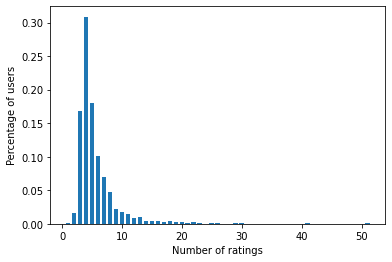

In [ ]:
x = np.unique(statistics)
counted = Counter(statistics)
sum_ = sum(counted.values())
y = []
for key in x:
    tmp = counted[key] / sum_
    y.append(tmp)
plt.bar(x, y)
plt.xlabel("Number of ratings")
plt.ylabel("Percentage of users")
plt.show()

Compute the number of ratings per item in the training set.

In [ ]:
tmp = train.drop_duplicates(subset="asin",keep='first')
print(len(tmp))
statistics = train.asin.value_counts()
statistics = statistics.tolist()
print(statistics)

800
[226, 226, 224, 91, 66, 65, 65, 58, 56, 55, 50, 50, 47, 45, 44, 42, 42, 42, 41, 38, 35, 35, 35, 34, 34, 34, 34, 33, 33, 33, 33, 32, 32, 31, 31, 31, 30, 30, 29, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

Show a barplot of the number of ratings ordered by decreasing frequency.

Training set:


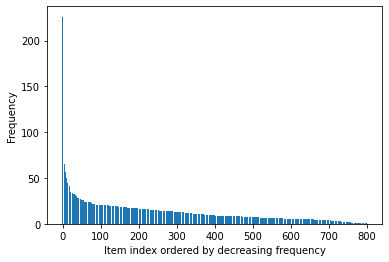

In [ ]:
print("Training set:")
plt.bar(np.arange(len(statistics)), statistics)
plt.xlabel("Item index ordered by decreasing frequency")
plt.ylabel("Frequency")
plt.show()

Compute the mean rating per user in the training set. Show the summary statistics of the rating means.

In [ ]:
tmp = train.groupby("reviewerID").agg({'overall':'mean'})
count = len(tmp)
statistics = tmp.overall.values
statistics = statistics.tolist()

mean = np.mean(statistics)
std = np.std(statistics, ddof = 1)
min = np.min(statistics)
percentage = np.percentile(statistics, q=[25, 50, 75])
twentyfive = percentage[0]
fifity = percentage[1]
seventyfive = percentage[2]
max = np.max(statistics)

print("Summary statistics:")
print("count", format(count, '.6f'))
print("mean", format(mean, '.6f'))
print("std", format(std, '.6f'))
print("min", format(min, '.6f'))
print("25%", format(twentyfive, '.6f'))
print("50%", format(fifity, '.6f'))
print("75%", format(seventyfive, '.6f'))
print("max", format(max, '.6f'))

Summary statistics:
count 1824.000000
mean 3.820163
std 1.111548
min 1.000000
25% 3.250000
50% 4.000000
75% 4.800000
max 5.000000


Compute with mean rating per item in the training set. Show the summary statistics of the rating means.

In [ ]:
tmp = train.groupby("asin").agg({'overall':'mean'})
count = len(tmp)
statistics = tmp.overall.values
statistics = statistics.tolist()

mean = np.mean(statistics)
std = np.std(statistics, ddof = 1)
min = np.min(statistics)
percentage = np.percentile(statistics, q=[25, 50, 75])
twentyfive = percentage[0]
fifity = percentage[1]
seventyfive = percentage[2]
max = np.max(statistics)

print("Summary statistics:")
print("count", format(count, '.6f'))
print("mean", format(mean, '.6f'))
print("std", format(std, '.6f'))
print("min", format(min, '.6f'))
print("25%", format(twentyfive, '.6f'))
print("50%", format(fifity, '.6f'))
print("75%", format(seventyfive, '.6f'))
print("max", format(max, '.6f'))

Summary statistics:
count 800.000000
mean 3.584347
std 0.836750
min 1.000000
25% 3.033333
50% 3.722222
75% 4.166667
max 5.000000


Show the top 5 most popular items according to the mean rating per item.

In [ ]:
popular_item = dict()

tmp_index = tmp.overall.index.tolist()

for i in range(len(statistics)):
    tmp_ = tmp_index[i]
    popular_item[tmp_] = statistics[i]

popular_item = sorted(popular_item.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)


for i in range(5):
    print(popular_item[i])
    

('B01EB06R10', 5.0)
('B01617VVYY', 5.0)
('B00PG8FWS6', 5.0)
('B00LYYMXF6', 5.0)
('B00ENFYLRQ', 5.0)


# 2. Collaborative Filtering Recommender System

## 2.1 
Define a neighborhood-based and a latent factor model that uses the observed user-item ratings in the training set to predict the unobserved ratings. Report your choice of models.

In [ ]:
reader = Reader(rating_scale=(1, 5))
training = Dataset.load_from_df(train[['reviewerID', 'asin', 'overall']], reader)

## 2.2 
Use 3-fold cross-validation on the training set to tune the hyperparameters of the chosen models (similarity measure and number of neighbors for the neighborhood-based model; number of latent factors and number of epochs for the latent factor model). Report the optimal hyperparameters together with the corresponding validation Root Mean Square Errors averaged over the 3 folds.

In [ ]:
param_grid1 = {'k': [1, 5, 10, 15, 20],
              'sim_options': {'name': ['cosine', 'pearson_baseline']}}

gs1 = GridSearchCV(KNNWithMeans, param_grid1, measures=['rmse'], cv=3)
gs1.fit(training)

print(gs1.best_params)
print(gs1.best_score)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity mat

In [ ]:
param_grid2 = {'n_factors': [20, 50, 70, 100],
              'n_epochs': [100, 500, 1000]}

gs2 = GridSearchCV(SVD, param_grid2, measures=['rmse'], cv=3)
gs2.fit(training)

print(gs2.best_params)
print(gs2.best_score)

{'rmse': {'n_factors': 70, 'n_epochs': 1000}}
{'rmse': 1.1371718251954919}


## 2.3
Run the models with the optimal hyperparameters to the whole training set.

neighborhood-based model:

In [ ]:
knn = gs1.best_estimator['rmse']
knn.fit(training.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


latent factor model:

In [ ]:
svd = gs2.best_estimator['rmse']
svd.fit(training.build_full_trainset())

## 2.4
Use the final models to rank the non-rated items for each user. This ranking will be used for the evaluation part next week.

In [ ]:
user_item = train.pivot(index='reviewerID', columns='asin', values='overall')
user_item = user_item.fillna(0)

reviewers = user_item.index.tolist()
items = list(user_item)

In [ ]:
trainset = training.build_full_trainset()

test_from_train = trainset.build_anti_testset()

pred_lf_list = svd.test(test_from_train)

pred_nb_list = knn.test(test_from_train)

# 3. Evaluation of Recommender Systems

## 3.1 
Measure the error of the system’s predicted ratings for Software products (Root Mean Square Error, RMSE).

In [ ]:
# Detect users from training set that are not in test
nb_users = set([pred.uid for pred in pred_nb_list])
lf_users = set([pred.uid for pred in pred_lf_list])
nb_users_in_pred_but_not_in_test = list(nb_users.difference(set(test['reviewerID'])))
lf_users_in_pred_but_not_in_test = list(lf_users.difference(set(test['reviewerID'])))
assert nb_users_in_pred_but_not_in_test == lf_users_in_pred_but_not_in_test
print(f"There are {len(lf_users_in_pred_but_not_in_test)} users in the training set that are not in the test set.")

# Remove these users' predictions for evaluation
### YOUR CODE HERE ###
pred_nb_list_new = []
pred_lf_list_new = []

for pred in pred_nb_list:
    if pred.uid not in nb_users_in_pred_but_not_in_test:
        pred_nb_list_new += [pred]
        
for pred in pred_lf_list:
    if pred.uid not in lf_users_in_pred_but_not_in_test:
        pred_lf_list_new += [pred]
        
print("Evaluating the systems with", len(pred_nb_list_new), "predictions for users in the test split.")

There are 113 users in the training set that are not in the test set.
Evaluating the systems with 1359246 predictions for users in the test split.


In [ ]:
nb_rmse = rmse(pred_nb_list_new)
lf_rmse = rmse(pred_lf_list_new)

print("RMSE for Neighborhood based Collaborative Filtering:", nb_rmse)
print("RMSE for Latent Factor based Collaborative Filtering:", lf_rmse)

RMSE: 0.9832
RMSE: 0.6908
RMSE for Neighborhood based Collaborative Filtering: 0.9832319467555981
RMSE for Latent Factor based Collaborative Filtering: 0.6908039387974252


## 3.2
Generate the top-k (with k = 5) recommendation for each test user:

In [ ]:
# this part is from the document of the scipy.surprise
def get_top_k_recommen(predictions, k):
    top_k = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_k[uid].append((iid, est))

    for uid, ratings in top_k.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = ratings[:k]

    return top_k

neighborhood-based model:

In [ ]:
nb_top_five = get_top_k_recommen(pred_nb_list_new, 5)

latent factor model:

In [ ]:
lf_top_five = get_top_k_recommen(pred_lf_list_new, 5)

Compute the precision@k, averaged across users, Mean Average Precision (MAP@k), and Mean Reciprocal Rank (MRR@k):

In [ ]:
test_user_item = test.pivot(index='reviewerID', columns='asin', values='overall')
test_user_item = test_user_item.fillna(0)
test_user_item

asin,0321700945,0321719816,0763855553,1413313728,1426296355,1600775411,B00003IRBV,B00004TYCR,B000050HEI,B00005NCJ3,...,B01DEG0SGC,B01E6C5D1S,B01EB06QUM,B01EB06R10,B01F4PYHX6,B01F7RJHIQ,B01FFVDY9M,B01H39M7ME,B01HAP3NUG,B01HAP47PQ
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1075X1Q4M3S78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10C5CJK1YKGV0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10CRW7XRJBJ2G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZD8SMNGQI98O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZQGJ5CEAJGXB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZW10G02DNJI4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# the idea of this part is from the document of the scipy.surprise
def create_dict(predictions):
    user_est_true = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        if iid in list(test_user_item):
            r_ui = test_user_item.at[uid, iid]
        else:
            r_ui = 0
        user_est_true[uid].append((est, r_ui))
        
    return user_est_true

In [ ]:
# the idea of this part is from the document of the scipy.surprise
def precision(user_ratings, threshold, k):
    n_rel_and_rec_k = sum((r_ui >= threshold)
                            for (est, r_ui) in user_ratings[:k])

    return n_rel_and_rec_k / k 

In [ ]:
# the idea of this part is from the document of the scipy.surprise
def precision_AP_RR_at_k(predictions, k, threshold):
    user_est_true = create_dict(predictions)
    
    precisions = dict()
    RRs = dict()
    APs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        precisions[uid] = precision(user_ratings, threshold, k)
        
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        
        RRs[uid] = 0
        for i in range(k):
            (est, r_ui) = user_ratings[i]
            if r_ui >= threshold:
                RRs[uid] = 1 / (i+1)
                break
                
        sum_P = 0
        for i in range(1, k+1):
            (est, r_ui) = user_ratings[i-1]
            if r_ui >= threshold:
                prec = precision(user_ratings, threshold, i)
                sum_P += prec
                
        APs[uid] = sum_P / n_rel if n_rel != 0 else 0
                
    return precisions, RRs, APs

In [ ]:
print("Metrics for Neighborhood based CF:")

k = 5 
precisions_nb, RRs_nb, APs_nb = precision_AP_RR_at_k(pred_nb_list_new, k, 4.0)   
print("Averaged P@5:", sum(prec for prec in precisions_nb.values()) / len(precisions_nb))
print("MAP@5:", sum(prec for prec in APs_nb.values()) / len(APs_nb))
print("MRR@5:", sum(prec for prec in RRs_nb.values()) / len(RRs_nb))

Metrics for Neighborhood based CF:
Averaged P@5: 0.005610753945061366
MAP@5: 0.012935904928891486
MRR@5: 0.012935904928891486


In [ ]:
print("Metrics for Latent Factor based CF:")

k = 5
precisions_lf, RRs_lf, APs_lf = precision_AP_RR_at_k(pred_lf_list_new, k, 4.0)
print("Averaged P@5:", sum(prec for prec in precisions_lf.values()) / len(precisions_lf))
print("MAP@5:", sum(prec for prec in APs_lf.values()) / len(APs_lf))
print("MRR@5:", sum(prec for prec in RRs_lf.values()) / len(RRs_lf))

Metrics for Latent Factor based CF:
Averaged P@5: 0.0014026884862653418
MAP@5: 0.003009935710111047
MRR@5: 0.003009935710111047


## 3.3
Compute the system’s hit rate averaged over the total number of users in the test set.

In [ ]:
def hit_rate_at_k(predictions, k, threshold):
    user_est_true = create_dict(predictions)

    HRs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        HRs[uid] = 0
        for i in range(k):
            (est, r_ui) = user_ratings[i]
            if r_ui >= threshold:
                HRs[uid] = 1
                break
                
    return HRs

In [ ]:
print("Hit Rate for Neighborhood based CF:")

k = 5
HRs_nb = hit_rate_at_k(pred_nb_list_new, k, 4.0)
print("Hit Rate (top-5):", sum(prec for prec in HRs_nb.values()) / len(HRs_nb))

Hit Rate for Neighborhood based CF:
Hit Rate (top-5): 0.028053769725306838


In [ ]:
print("Hit Rate for Latent Factor based CF:")

k = 5
HRs_lf = hit_rate_at_k(pred_lf_list_new, k, 4.0)
print("Hit Rate (top-5):", sum(prec for prec in HRs_lf.values()) / len(HRs_lf))

Hit Rate for Latent Factor based CF:
Hit Rate (top-5): 0.0070134424313267095


## 3.3
Error Analysis for the neighborhood-based CF:

Ordered by the value of the column “unixReviewTime”, take the first and last users from the test set as reference and retrieve the 10 nearest neighbours of each reference user. Print their rate history and analyse their predictions.


In [ ]:
test = test.sort_values(by=['unixReviewTime'])

first_user = test.iloc[0]["reviewerID"]
last_user = test.iloc[-1]["reviewerID"]

print("The first user from the test set is:", first_user)
print("The last user from the test set is:", last_user)

The first user from the test set is: A2G0O4Y8QE10AE
The last user from the test set is: A2SACTIFMC5DXO


In [ ]:
train_index_first = reviewers.index(first_user)
train_index_last = reviewers.index(last_user)

first_user_neighbors = knn.get_neighbors(train_index_first, k=10)

last_user_neighbors = knn.get_neighbors(train_index_last, k=10)

first_group = []
last_group = []

first_group.append(first_user)
last_group.append(last_user)

print('The 10 nearest neighbors of the first user are:')
for user in first_user_neighbors:
    print(test.iloc[user]["reviewerID"])
    first_group.append(test.iloc[user]["reviewerID"])
    
print()    
print('The 10 nearest neighbors of the last user are:')
for user in last_user_neighbors:
    print(test.iloc[user]["reviewerID"])
    last_group.append(test.iloc[user]["reviewerID"])

The 10 nearest neighbors of the first user are:
A2G0O4Y8QE10AE
AT4AV7XIQDKQP
A1MJWOYNJSZPPJ
A3TLPNECI4DG3N
A1GOKUUDRB63FQ
A3NG3IWQSNNMHD
A3A8ZWV1PQWXK5
AFFTVSSV0D5A1
A1C9C1QOQB94RT
AVYMBTCXYREXE

The 10 nearest neighbors of the last user are:
AXO1SEG20M3VX
A1PI8VBCXXSGC7
A3UFSSZ700NAYC
A2JS2PPR6FW42E
A2SACTIFMC5DXO
A2YKWYC3WQJX5J
A2G0O4Y8QE10AE
AT4AV7XIQDKQP
A1MJWOYNJSZPPJ
A3TLPNECI4DG3N


In [ ]:
def true_est(users, predictions):
    user_est_true = defaultdict(list)
    
    for uid, iid, _, est, _ in predictions:
        if (uid in users) and (user_item.at[uid, iid] != 0):
            print("??")
            r_ui = user_item.at[uid, iid]
            user_est_true[uid].append((iid, (est, r_ui)))
        
    return user_est_true

In [ ]:
# user_est_true = true_est(first_group, pred_nb_list_new)
# print(first_group)
# print(user_est_true[1])
for uid, iid, _, est, _ in pred_nb_list_new:
    if uid in first_group:
#         print(uid)
#        print(user_item.at[uid, iid]) 
        pass

For those users or products that your model performs poorly on (RR ≤ 0.05), discuss the potential reasons behind.

In [ ]:
sum_ = 0
for (key, value) in RRs_nb.items():
    if value <= 0.05:
        sum_ += 1
        
print(sum_)

1663


# 4. Text Representation

## 4.1
Select the column “title” from the metadata (only for the products rated in our small subset of the dataset) and apply the following preprocessing to clean up the data: tokenization, transform to lowercase, remove stopwords, stemming. Report the vocabulary size after preprocessing. There are many libraries you can use, including but not limited to, NLTK, spaCy or CoreNLP (requires Java).

In [ ]:
metadata = getDF(datapath + meta_file)

metadata = metadata.drop_duplicates(subset=["asin"], keep="last")

tmp1 = test.asin.tolist()
tmp2 = train.asin.tolist()
mask = tmp1 + tmp2
metadata = metadata[metadata.asin.isin(mask)]

print("Total number of products:", len(metadata))

Total number of products: 801


In [ ]:
metadata

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
88,[],,[This complete training program from Adobe Pre...,,Learn Adobe Photoshop Lightroom 3 by Video,[],,Peach Pit Press,[],"8,501 in Software (",[],Software,,</div>,$24.99,0321700945,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
89,[],,[This complete training program from Adobe Pre...,,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[],,Peach Pit Press,[],"9,956 in Software (",[],Software,,</div>,$35.23,0321719816,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
90,[],,[This complete training program from Adobe Pre...,,Learn Adobe Flash Professional CS5 by Video: C...,[],,Peach Pit Press,[],"11,954 in Software (",[],Software,,</div>,,0321719824,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
211,"[Software, Business &amp; Office, Office Suites]",,[Office 365 comes fully loaded with the latest...,,Microsoft Office 365 Home | 1-year subscriptio...,"[B073W4MPJF, B0144NYGJY, B074FLKWSX, B00ZSHDJ4...",,Microsoft,[1-year subscription for 2-5 users. For instru...,61 in Software (,"[B00HV9IM58, B0148BYIAO, B0114ZV22E, B07FTQMWH...",Software,,</div>,$90.05,0763855553,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
312,"[Software, Education &amp; Reference, Religion]",,[Glo features five interactive browsing lenses...,,"NIV, GLO Premium, DVD: Multi-device",[],,Immersion Digital,[],"6,394 in Software (","[B00FDZKSP4, 0981990207, 1602558558]",Software,,</div>,,0982697813,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26667,"[Software, Business & Office, Word Processing]",,[Microsoft Office 2010 gives you powerful new ...,,Microsoft Office Home and Student 2010 Family ...,"[1936220156, 193622013X, 1936220180, 193622025...",,Microsoft,[Rich and powerful new ways to deliver your wo...,"[>#191 in Software (See Top 100 in Software), ...","[B0148BYIAO, B0114ZV22E, B000VEH6VG, B0036Z0NZ...",Software,,,$259.99,B01F7RJHIQ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
26686,"[Software, Photography]",,[Make your best work even better with Corel Af...,,Corel AfterShot Pro 3 Photo Editing Software f...,[],,Corel,[Faster photo workflow gets you back to your c...,"1,658 in Software (","[B0799C43LY, B01JA1F4FA, B01HTAOZTK, B07FV5KKS...",Software,,</div>,$44.00,B01FFVDY9M,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{' Product Dimensions: ': '5.2 x 0.1 ...
26767,"[Software, Digital Software, Video, Compositin...",,"[<div>, onlineTV gives you access to hundreds ...",,onlineTV Free [Download],"[B01DEG0SGC, B00OSDY8PI, B01DEEGRY6, B06XHSTX7...",,concept/design GmbH,"[TV, Music]",[],"[B01KQEW65G, B00OM4DJDA, B00N28818A, B077PYZ5Y...",Software,,</div>,,B01H39M7ME,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{'Note:': 'Gifting is not available for this i...
26776,"[Software, Photography]",,"[Get the power, creativity and control you nee...",,Pinnacle Studio 20 Ultimate (Old Version),"[B00EAS14KI, 0993487106, B01HTAOZUE, B01KWXVFG...",,Pinnacle Systems,"[New - Motion Tracking with Mosaic Blur, New -...","1,066 in Software (","[B07FY5BD28, B073X69CD8, B07FXX4NXQ, B073X5XWC...",Software,,</div>,$35.64,B01HAP47PQ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{' Product Dimensions: ': '5.2 x 1.2 ...


In [ ]:
metadata['token'] = metadata['title'].apply(lambda title:word_tokenize(title)) 
tmp = metadata.token.tolist()
tokens = []
for t in tmp:
    tokens += t
   
vocabulary_size_before = len(set(tokens))

print("Vocabulary size before preprocessing:", vocabulary_size_before)

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

metadata['token'] = metadata['token'].apply(lambda tokens : [token for token in tokens if token.isalpha()])
metadata['token'] = metadata['token'].apply(lambda tokens : [token.lower() for token in tokens]) 
metadata['token'] = metadata['token'].apply(lambda tokens : [token for token in tokens if token not in stop_words])
metadata['token'] = metadata['token'].apply(lambda tokens : [ps.stem(token) for token in tokens])

tmp2 = metadata.token.tolist()
tokens2 = []
for t in tmp2:
    tokens2 += t
   
vocabulary_size_after = len(set(tokens2))

print("Vocabulary size after preprocessing:", vocabulary_size_after)

Vocabulary size before preprocessing: 967
Vocabulary size after preprocessing: 622


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 4.2
Represent each product in the TF-IDF vector space. You can use your preferred library for data analysis, like, for example, sikit-learn or gensim.


In [ ]:
tfidf_vectorizer = TfidfVectorizer()

twd = TreebankWordDetokenizer()

tokens_from_title = []
for t in tmp2:
    tokens_from_title += [twd.detokenize(t)]

TF_IDF = tfidf_vectorizer.fit_transform(tokens_from_title)

print("TF-IDF matrix shape:", TF_IDF.shape)

TF-IDF matrix shape: (801, 618)


## 4.3
Represent each product using pretrained word embeddings (e.g., GloVe, word2vec).


In [ ]:
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
w2v = []

null_ = np.zeros((300,))

for l in tmp2:
    vecs = null_
    count = 0
    for t in l:
        try:
            vec = word2vec_vectors[t]
            vecs += vec
            count += 1
        except KeyError:
            pass
    vec_sen = vecs / count if count != 0 else null_
    w2v.append(vec_sen)

print(len(w2v))

801


## 4.4
Explore the similarity between products within the vector spaces by computing their cosine similarity. Compare results obtained with TF-IDF and the word embeddings. Discuss what you find.

Results obtained with TF-IDF:

In [ ]:
cosine_sim_TF = cosine_similarity(TF_IDF, TF_IDF)

products = metadata.asin.tolist()

num1 = -1
num2 = -1
num3 = -1

for i in range(len(products)):
    if products[i] == '0321719824':
        num1 = i
    if products[i] == '0321719816':
        num2 = i
    if products[i] == '0321700945':
        num3 = i
        
print(num1, num2, num3)

sim1_TF = cosine_sim_TF[num1][num2]
sim2_TF = cosine_sim_TF[num1][num3]
sim3_TF = cosine_sim_TF[num2][num3]

print("Similarity between '0321719824' and '0321719816':", sim1_TF)
print("Similarity between '0321719824' and '0321700945':", sim2_TF)
print("Similarity between '0321719816' and '0321700945':", sim3_TF)

2 1 0
Similarity between '0321719824' and '0321719816': 0.6637983206606705
Similarity between '0321719824' and '0321700945': 0.3810011268188509
Similarity between '0321719816' and '0321700945': 0.40876431701370586


Results obtained with word2vec:

In [ ]:
cosine_sim_w2v = cosine_similarity(w2v, w2v)

sim1_w2v = cosine_sim_w2v[num1][num2]
sim2_w2v = cosine_sim_w2v[num1][num3]
sim3_w2v = cosine_sim_w2v[num2][num3]

print("Similarity between '0321719824' and '0321719816':", sim1_w2v)
print("Similarity between '0321719824' and '0321700945':", sim2_w2v)
print("Similarity between '0321719816' and '0321700945':", sim3_w2v)

Similarity between '0321719824' and '0321719816': 0.9564685644303779
Similarity between '0321719824' and '0321700945': 0.7792596994774905
Similarity between '0321719816' and '0321700945': 0.8913580591164871


# 5. Content-Based Recommender System



## 5.1 
Transform the “title” column of each product into a TF-IDF score or other numerical value, e.g., token-count based, that can represent the summaries. Select other factors that can be used as product features.

In [ ]:
token_count = []
for t in tmp2:
    token_count.append(len(t))
    
metadata['token_count'] = token_count
metadata

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,...,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,token,token_count
88,[],,[This complete training program from Adobe Pre...,,Learn Adobe Photoshop Lightroom 3 by Video,[],,Peach Pit Press,[],"8,501 in Software (",...,Software,,</div>,$24.99,0321700945,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,"[learn, adob, photoshop, lightroom, video]",5
89,[],,[This complete training program from Adobe Pre...,,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[],,Peach Pit Press,[],"9,956 in Software (",...,Software,,</div>,$35.23,0321719816,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,"[learn, adob, dreamweav, video, core, train, w...",8
90,[],,[This complete training program from Adobe Pre...,,Learn Adobe Flash Professional CS5 by Video: C...,[],,Peach Pit Press,[],"11,954 in Software (",...,Software,,</div>,,0321719824,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,"[learn, adob, flash, profession, video, core, ...",10
211,"[Software, Business &amp; Office, Office Suites]",,[Office 365 comes fully loaded with the latest...,,Microsoft Office 365 Home | 1-year subscriptio...,"[B073W4MPJF, B0144NYGJY, B074FLKWSX, B00ZSHDJ4...",,Microsoft,[1-year subscription for 2-5 users. For instru...,61 in Software (,...,Software,,</div>,$90.05,0763855553,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,"[microsoft, offic, home, subscript, user, key,...",7
312,"[Software, Education &amp; Reference, Religion]",,[Glo features five interactive browsing lenses...,,"NIV, GLO Premium, DVD: Multi-device",[],,Immersion Digital,[],"6,394 in Software (",...,Software,,</div>,,0982697813,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,"[niv, glo, premium, dvd]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26667,"[Software, Business & Office, Word Processing]",,[Microsoft Office 2010 gives you powerful new ...,,Microsoft Office Home and Student 2010 Family ...,"[1936220156, 193622013X, 1936220180, 193622025...",,Microsoft,[Rich and powerful new ways to deliver your wo...,"[>#191 in Software (See Top 100 in Software), ...",...,Software,,,$259.99,B01F7RJHIQ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{},"[microsoft, offic, home, student, famili, pack...",8
26686,"[Software, Photography]",,[Make your best work even better with Corel Af...,,Corel AfterShot Pro 3 Photo Editing Software f...,[],,Corel,[Faster photo workflow gets you back to your c...,"1,658 in Software (",...,Software,,</div>,$44.00,B01FFVDY9M,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{' Product Dimensions: ': '5.2 x 0.1 ...,"[corel, aftershot, pro, photo, edit, softwar, ...",8
26767,"[Software, Digital Software, Video, Compositin...",,"[<div>, onlineTV gives you access to hundreds ...",,onlineTV Free [Download],"[B01DEG0SGC, B00OSDY8PI, B01DEEGRY6, B06XHSTX7...",,concept/design GmbH,"[TV, Music]",[],...,Software,,</div>,,B01H39M7ME,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{'Note:': 'Gifting is not available for this i...,"[onlinetv, free, download]",3
26776,"[Software, Photography]",,"[Get the power, creativity and control you nee...",,Pinnacle Studio 20 Ultimate (Old Version),"[B00EAS14KI, 0993487106, B01HTAOZUE, B01KWXVFG...",,Pinnacle Systems,"[New - Motion Tracking with Mosaic Blur, New -...","1,066 in Software (",...,Software,,</div>,$35.64,B01HAP47PQ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{' Product Dimensions: ': '5.2 x 1.2 ...,"[pinnacl, studio,

## 5.2
After you represent each product in a vector space, represent each user in the same vector space. This can be done by using an average of the items the user rates. Instead of a simple average, a weighted average can be used, where the weight is the rating for the item by the user. Note: the user representations and item representations all have the same number of dimensions.

In [ ]:
print(TF_IDF.shape)

user_profiles = dict()
not_rated = dict()
rated_items = dict()

for reviewer in reviewers:
    scores = 0
    count = 0
    not_item = []
    rated_item = []
    for item in items:
        weight = user_item.at[reviewer, item]
        if weight != 0:
            count += 1
            index_ = products.index(item)
            tmp = TF_IDF[index_]
            score = weight * tmp
            scores = scores + score 
            rated_item += [item]
            
        else:
            not_item += [item]
            
    user_profiles[reviewer] = scores / count if count != 0 else 0
    not_rated[reviewer] = not_item
    rated_items[reviewer] = rated_item
    
print(len(reviewers), "users loaded")

(801, 618)
1824 users loaded


## 5.3
Calculate the user-item rating for an item by using a similarity metric between the user and the item. A similarity metric such as cosine distance or Euclidean distance can be used.

In [ ]:
cosine_similarity_matrix = pd.DataFrame(columns=items, index=reviewers)

for reviewer in reviewers:
    user_profile = user_profiles[reviewer]
    for item in not_rated[reviewer]:
        index_ = products.index(item)
        item_profile = TF_IDF[index_]
        cosine_sim_ = cosine_similarity(user_profile, item_profile)
        cosine_similarity_matrix.at[reviewer, item] = cosine_sim_
        
cosine_similarity_matrix = cosine_similarity_matrix.fillna(-1)
cosine_similarity_matrix

,0321700945,0321719816,0321719824,0763855553,0982697813,1413313701,1413313728,1426296355,1600775411,1615354336,...,B01DEG0SGC,B01E6C5D1S,B01EB06QUM,B01EB06R10,B01F4PYHX6,B01F7RJHIQ,B01FFVDY9M,B01H39M7ME,B01HAP3NUG,B01HAP47PQ
A100UD67AHFODS,[[0.0]],[[0.0]],[[0.020523190562067778]],[[0.02203388646059032]],[[0.0]],[[0.06887075623255898]],[[0.061871600917835834]],[[0.0]],[[0.0]],[[0.0]],...,[[0.019720393608293557]],[[0.0923961685470148]],[[0.11027812858255437]],[[0.0]],[[0.019635896657998617]],[[0.04414745376257842]],[[0.0]],[[0.039582598850084284]],[[0.06879275827992905]],[[0.06984736078585144]]
A105S56ODHGJEK,[[0.0]],[[0.0]],[[0.013195356729555543]],[[0.18487214129282223]],[[0.01834370975334325]],[[0.16408461856698164]],[[0.1693383419457748]],[[0.01128123556258893]],[[0.1253575997739267]],[[0.06514090101733727]],...,[[0.0029455247020664073]],[[0.00525601534092005]],[[0.5076831750292645]],[[0.2650993173922925]],[[0.015598576620734987]],[[0.29838877552084736]],[[0.13879020262198796]],[[0.005912231013273245]],[[0.16389878839745262]],[[0.18227739299402707]]
A1075X1Q4M3S78,[[0.0]],[[0.0]],[[0.0]],[[0.08781759219612516]],[[0.0]],[[0.377247051280034]],[[0.3389084174625935]],[[0.0]],[[0.0]],[[0.0]],...,[[0.0]],[[0.0]],[[0.1373035461534448]],[[0.0830569409967856]],[[0.0]],-1,[[0.0]],[[0.0]],[[0.03975852043465181]],[[0.04036802405582561]]
A10C5CJK1YKGV0,[[0.0]],[[0.0]],[[0.0]],[[0.0]],[[0.0]],[[0.18560315818111547]],[[0.15669456276401922]],[[0.0]],[[0.22863786258077148]],[[0.0]],...,[[0.0]],[[0.0]],[[0.2529303024034064]],[[0.11517885175894023]],[[0.013420161216197376]],[[0.043159529206081466]],[[0.17385015325226633]],[[0.0]],[[0.18539295769644398]],[[0.11698928222392341]]
A10CRW7XRJBJ2G,[[0.0]],[[0.0]],[[0.0]],[[0.0]],[[0.0]],[[0.07524657381964857]],[[0.0675994607941128]],[[0.0]],[[0.06917446034738654]],[[0.0]],...,[[0.09074056973992259]],[[0.09677505823020165]],[[0.15781612260964795]],[[0.0]],[[0.02016069423221104]],[[0.02679888000016078]],[[0.049773831379902767]],[[0.10885746396618547]],[[0.07516135508500116]],[[0.07631358906141217]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZD8SMNGQI98O,[[0.0]],[[0.0]],[[0.0]],[[0.1373901149980884]],[[0.0]],[[0.19697429452955223]],[[0.2395316570827769]],[[0.0]],[[0.04813204868194655]],[[0.1088777307447619]],...,[[0.029435658210627276]],[[0.052525198996497206]],[[0.19715610975236894]],[[0.0981195703049327]],[[0.014027944871177908]],[[0.05947297947661326]],[[0.18055137768465654]],[[0.059082991647258054]],[[0.34322180633898325]],[[0.35789749473369414]]
AZQGJ5CEAJGXB,[[0.0]],[[0.0]],[[0.0]],[[0.10162031653007565]],[[0.0]],[[0.1750650247046351]],[[0.06187699742892823]],[[0.0]],[[0.0]],[[0.20045474617292508]],...,[[0.0]],[[0.0]],[[0.05100592654266298]],[[0.07915553377683886]],[[0.08684665895713116]],[[0.02453028780685954]],[[0.0]],[[0.0]],-1,[[0.7004008339004225]]
AZW10G02DNJI4,[[0.0]],[[0.0]],[[0.0]],[[0.0]],[[0.0]],[[0.09414828204435316]],[[0.08458023771480272]],[[0.0]],[[0.028658328744965038]],[[0.0]],...,[[0.08013859417680673]],[[0.07225571281569873]],[[0.11655339752742429]],[[0.0]],[[0.07104292210362087]],[[0.01844578920832167]],[[0.05405346473379599]],[[0.0812768682140795]],[[0.051733897554727265]],[[0.052526985364643806]]
AZYJE40XW6MFG,[[0.0]],[[0.0]],[[0.0]],[[0.01694947962993261]],-1,[[0.20330979558147752]],[[0.09346880611338818]],[[0.0]],[[0.0]],[[0.0]],...,[[0.0]],[[0.0]],[[0.13770315255471208]],[[0.013202528324637702]],[[0.0]],[[0.037054427496396994]],[[0.0]],[[0.0]],[[0.4446292847807721]],[[0.3507704403537877]]


Report Precision@5, MAP@5, MRR@5 and the hit rate using the test set. Compare the results with the models from previous weeks.

In [ ]:
test_reviewers = test_user_item.index.tolist()
test_items = list(test_user_item)

In [ ]:
def create_dict_content(cosine_similarity):
    user_est_true = defaultdict(list)
    
    for uid in reviewers:
        for iid in not_rated[uid]:
            if uid not in test_reviewers:
                pass
            else:
                est = cosine_similarity.at[uid, iid]
                if iid in list(test_user_item):
                    r_ui = test_user_item.at[uid, iid]
                else:
                    r_ui = 0
                user_est_true[uid].append((est, r_ui))
        
    return user_est_true

In [ ]:
def hit_rate_at_k_content(cosine_similarity, k, threshold):
    user_est_true = create_dict_content(cosine_similarity)

    HRs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        HRs[uid] = 0
        for i in range(k):
            (est, r_ui) = user_ratings[i]
            if r_ui >= threshold:
                HRs[uid] = 1
                break
                
    return HRs

In [ ]:
def precision_AP_RR_at_k_content(cosine_similarity_matrix, k, threshold):
    user_est_true = create_dict_content(cosine_similarity_matrix)
    
    precisions = dict()
    RRs = dict()
    APs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        precisions[uid] = precision(user_ratings, threshold, k)
        
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        
        RRs[uid] = 0
        for i in range(k):
            (est, r_ui) = user_ratings[i]
            if r_ui >= threshold:
                RRs[uid] = 1 / (i+1)
                break
                
        sum_P = 0
        for i in range(1, k+1):
            (est, r_ui) = user_ratings[i-1]
            if r_ui >= threshold:
                prec = precision(user_ratings, threshold, i)
                sum_P += prec
                
        APs[uid] = sum_P / n_rel if n_rel != 0 else 0
                
    return precisions, RRs, APs

In [ ]:
k = 5
precisions, RRs, APs = precision_AP_RR_at_k_content(cosine_similarity_matrix, k, 4.0)
print("Averaged P@5:", sum(prec for prec in precisions.values()) / len(precisions))
print("MAP@5:", sum(prec for prec in APs.values()) / len(APs))
print("MRR@5:", sum(prec for prec in RRs.values()) / len(RRs))

Averaged P@5: 0.04161309175920542
MAP@5: 0.1622930060393531
MRR@5: 0.1622930060393531


In [ ]:
k = 5
HRs = hit_rate_at_k_content(cosine_similarity_matrix, k, 4.0)
print("Hit Rate (top-5):", sum(prec for prec in HRs.values()) / len(HRs))

Hit Rate (top-5): 0.20806545879602573


# 6. Hybrid Recommender System

## 6.1 
Weighted strategy that re-ranks the items by combining the individual rankings from the two models with some aggregate function such as the sum, average, minimum or maximum.


In [ ]:
hybrid1 = dict()

for reviewer in reviewers:
    not_items = not_rated[reviewer]
    model1_score = []
    model2_score = []
    for item in not_items:
        score1 = knn.predict(reviewer, item).est
        model1_score.append(score1)
        score2 = cosine_similarity_matrix.at[reviewer, item]
        model2_score.append(score2[0][0])

    hybrid_score = list(map(lambda x :x[0]+x[1], zip(model1_score, model2_score)))

    d = {'item_id': not_items,
         'model1_score': model1_score,
         'model2_score': model2_score}
    df = pd.DataFrame(data=d)
    tmp1 = (df["model1_score"] - df["model1_score"].mean()) / df["model1_score"].std() if df["model1_score"].std() != 0 else 0 
    tmp2 = (df["model2_score"] - df["model2_score"].mean()) / df["model2_score"].std() if df["model2_score"].std() != 0 else 0 
    df["hybrid_score"] = tmp1 + tmp2
    hybrid1[reviewer] = df

In [ ]:
hybrid1["A100UD67AHFODS"]

,item_id,model1_score,model2_score,hybrid_score
0,0321700945,5.000000,0.000000,-0.549277
1,0321719816,5.000000,0.000000,-0.549277
2,0321719824,5.000000,0.020523,-0.406199
3,0763855553,5.000000,0.022034,-0.395667
4,0982697813,5.000000,0.000000,-0.549277
...,...,...,...,...
791,B01F7RJHIQ,4.501238,0.044147,-4.547732
792,B01FFVDY9M,5.000000,0.000000,-0.549277
793,B01H39M7ME,5.000000,0.039583,-0.273325
794,B01HAP3NUG,5.000000,0.068793,-0.069684


## 6.2
Switching strategy that uses the recommendations from the collaborative filtering model for some users and the recommendations from the content-based model for other users chosen by a predefined condition.

In [ ]:
hybrid2 = dict()

expected_num = 8

for reviewer in reviewers:
    rates = rated_items[reviewer]
    not_items = not_rated[reviewer]
    hybrid_score = []
    score = -1
    for item in not_items:
        if len(rates) < expected_num:
#         content
            score = cosine_similarity_matrix.at[reviewer, item][0][0]
        else:
            score = knn.predict(reviewer, item).est
            
        hybrid_score.append(score)
    d = {'item_id': not_items,
         'hybrid_score': hybrid_score}
    df = pd.DataFrame(data=d)
    hybrid2[reviewer] = df   

In [ ]:
hybrid2["A100UD67AHFODS"]

,item_id,hybrid_score
0,0321700945,0.000000
1,0321719816,0.000000
2,0321719824,0.020523
3,0763855553,0.022034
4,0982697813,0.000000
...,...,...
791,B01F7RJHIQ,0.044147
792,B01FFVDY9M,0.000000
793,B01H39M7ME,0.039583
794,B01HAP3NUG,0.068793


## 6.3
Meta-level strategy where a level of one model is used as input to the other model.


In [ ]:
item_rated = dict()

for item in items:
    rate_item = []
    for reviewer in reviewers:
        if user_item.at[reviewer, item] != 0:
            rate_item += [reviewer]
            
    item_rated[item] = rate_item
    
print(item_rated["B01F4PYHX6"])    

['A1ZU55TM45Y2R8']


In [ ]:
user_item_user = dict()

for reviewer in reviewers:
    user_profile1 = user_profiles[reviewer]
    i_list = dict()
    for item in not_rated[reviewer]:
        rate_reviewers = item_rated[item]
        r_list = dict()
        for rate_reviewer in rate_reviewers:
            user_profile2 = user_profiles[rate_reviewer]
            tmp = cosine_similarity(user_profile1, user_profile2)[0][0]
            r_list[rate_reviewer] = tmp
        i_list[item] = r_list
        
    user_item_user[reviewer] = i_list

In [ ]:
hybrid3 = dict()

for reviewer in reviewers:
    i_list = user_item_user[reviewer]
    hybrid_score = []
    not_items = not_rated[reviewer]
    for item in not_items:
        r_list = i_list[item]
        r_list = sorted(r_list.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
        r_list = r_list[:5]
        
        score = 0
        weights = 0
        for (r, weight) in r_list:
            print(r, weight)
            s = knn.predict(r, item).est 
            s = s * weight
            weights += weight
            score += s
            
        hybrid_score.append(score / weights)
    d = {'item_id': not_items,
         'hybrid_score': hybrid_score}
    df = pd.DataFrame(data=d)
    hybrid3[reviewer] = df

In [ ]:
hybrid3["A100UD67AHFODS"]

## 6.4
Report Precision@5, MAP@5, MRR@5 and the hit rate using the test set. Compare the results with the models from previous weeks.

In [ ]:
def create_dict_hybrid(hybrid):
    user_est_true = defaultdict(list)
    
    for uid in reviewers:
        for iid in not_rated[uid]:
            if uid not in test_reviewers:
                pass
            else:
                tmp = hybrid[uid]
                s = tmp[tmp['item_id'] == iid]['hybrid_score']
                est = list(s)[0]
                if iid in list(test_user_item):
                    r_ui = test_user_item.at[uid, iid]
                else:
                    r_ui = 0
                user_est_true[uid].append((est, r_ui))
        
    return user_est_true

In [ ]:
def hit_rate_at_k_hybrid(hybrid, k, threshold):
    user_est_true = create_dict_hybrid(hybrid)

    HRs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        HRs[uid] = 0
        for i in range(k):
            (est, r_ui) = user_ratings[i]
            if r_ui >= threshold:
                HRs[uid] = 1
                break
                
    return HRs

In [ ]:
def precision_AP_RR_at_k_hybrid(hybrid, k, threshold):
    user_est_true = create_dict_hybrid(hybrid)
    
    precisions = dict()
    RRs = dict()
    APs = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        precisions[uid] = precision(user_ratings, threshold, k)
        
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        
        RRs[uid] = 0
        for i in range(k):
            (est, r_ui) = user_ratings[i]
            if r_ui >= threshold:
                RRs[uid] = 1 / (i+1)
                break
                
        sum_P = 0
        for i in range(1, k+1):
            (est, r_ui) = user_ratings[i-1]
            if r_ui >= threshold:
                prec = precision(user_ratings, threshold, i)
                sum_P += prec
                
        APs[uid] = sum_P / n_rel if n_rel != 0 else 0
                
    return precisions, RRs, APs

In [ ]:
print("Metrics for Hybrid Model 1:")

k = 5
precisions_hybrid1, RRs_hybrid1, APs_hybrid1 = precision_AP_RR_at_k_hybrid(hybrid1, k, 4.0)
print("Averaged P@5:", sum(prec for prec in precisions_hybrid1.values()) / len(precisions_hybrid1))
print("MAP@5:", sum(prec for prec in APs_hybrid1.values()) / len(APs_hybrid1))
print("MRR@5:", sum(prec for prec in RRs_hybrid1.values()) / len(RRs_hybrid1))

In [ ]:
print("Hit Rate for Hybrid Model 1:")

k = 5
HRs_hybrid1 = hit_rate_at_k_hybrid(hybrid1, k, 4.0)
print("Hit Rate (top-5):", sum(prec for prec in HRs_hybrid1.values()) / len(HRs_hybrid1))

In [ ]:
print("Metrics for hybrid model 2:")

k = 5
precisions_hybrid2, RRs_hybrid2, APs_hybrid2 = precision_AP_RR_at_k_hybrid(cosine_similarity_matrix, k, 4.0)
print("Averaged P@5:", sum(prec for prec in precisions_hybrid2.values()) / len(precisions_hybrid2))
print("MAP@5:", sum(prec for prec in APs_hybrid2.values()) / len(APs_hybrid2))
print("MRR@5:", sum(prec for prec in RRs_hybrid2.values()) / len(RRs_hybrid2))

In [ ]:
print("Hit Rate for Hybrid Model 2:")

k = 5
HRs_hybrid2 = hit_rate_at_k_hybrid(hybrid2, k, 4.0)
print("Hit Rate (top-5):", sum(prec for prec in HRs_hybrid2.values()) / len(HRs_hybrid2))

In [ ]:
print("Metrics for hybrid model 3:")

k = 5
precisions_hybrid1, RRs_hybrid1, APs_hybrid1 = precision_AP_RR_at_k_hybrid(cosine_similarity_matrix, k, 4.0)
print("Averaged P@5:", sum(prec for prec in precisions_hybrid1.values()) / len(precisions_hybrid1))
print("MAP@5:", sum(prec for prec in APs_hybrid3.values()) / len(APs_hybrid3))
print("MRR@5:", sum(prec for prec in RRs_hybrid3.values()) / len(RRs_hybrid3))

In [ ]:
print("Hit Rate for Hybrid Model 3:")

k = 5
HRs_hybrid3 = hit_rate_at_k_hybrid(hybrid3, k, 4.0)
print("Hit Rate (top-5):", sum(prec for prec in HRs_hybrid3.values()) / len(HRs_hybrid3))